In [1]:
from astroNN.datasets import load_galaxy10
# from tensorflow.keras import utils
import numpy as np
import matplotlib.pyplot as plt
# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/

2023-05-02 16:46:59.227612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 16:47:00.626057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/spcup2022/miniconda3/envs/spcup2023/lib/
2023-05-02 16:47:00.626198: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/spcup2022/miniconda3/envs/spcup2023/lib/
2023-05-02 16:47:00.626209

In [2]:
idxs = [11170, 10609, 17689, 14521, 3994, 14633, 1938, 12871, 9254, 10513, 9871]

In [3]:
images, labels = load_galaxy10()

/home/spcup2022/.astroNN/datasets/Galaxy10_DECals.h5 was found!


In [3]:
images.shape

(17736, 256, 256, 3)

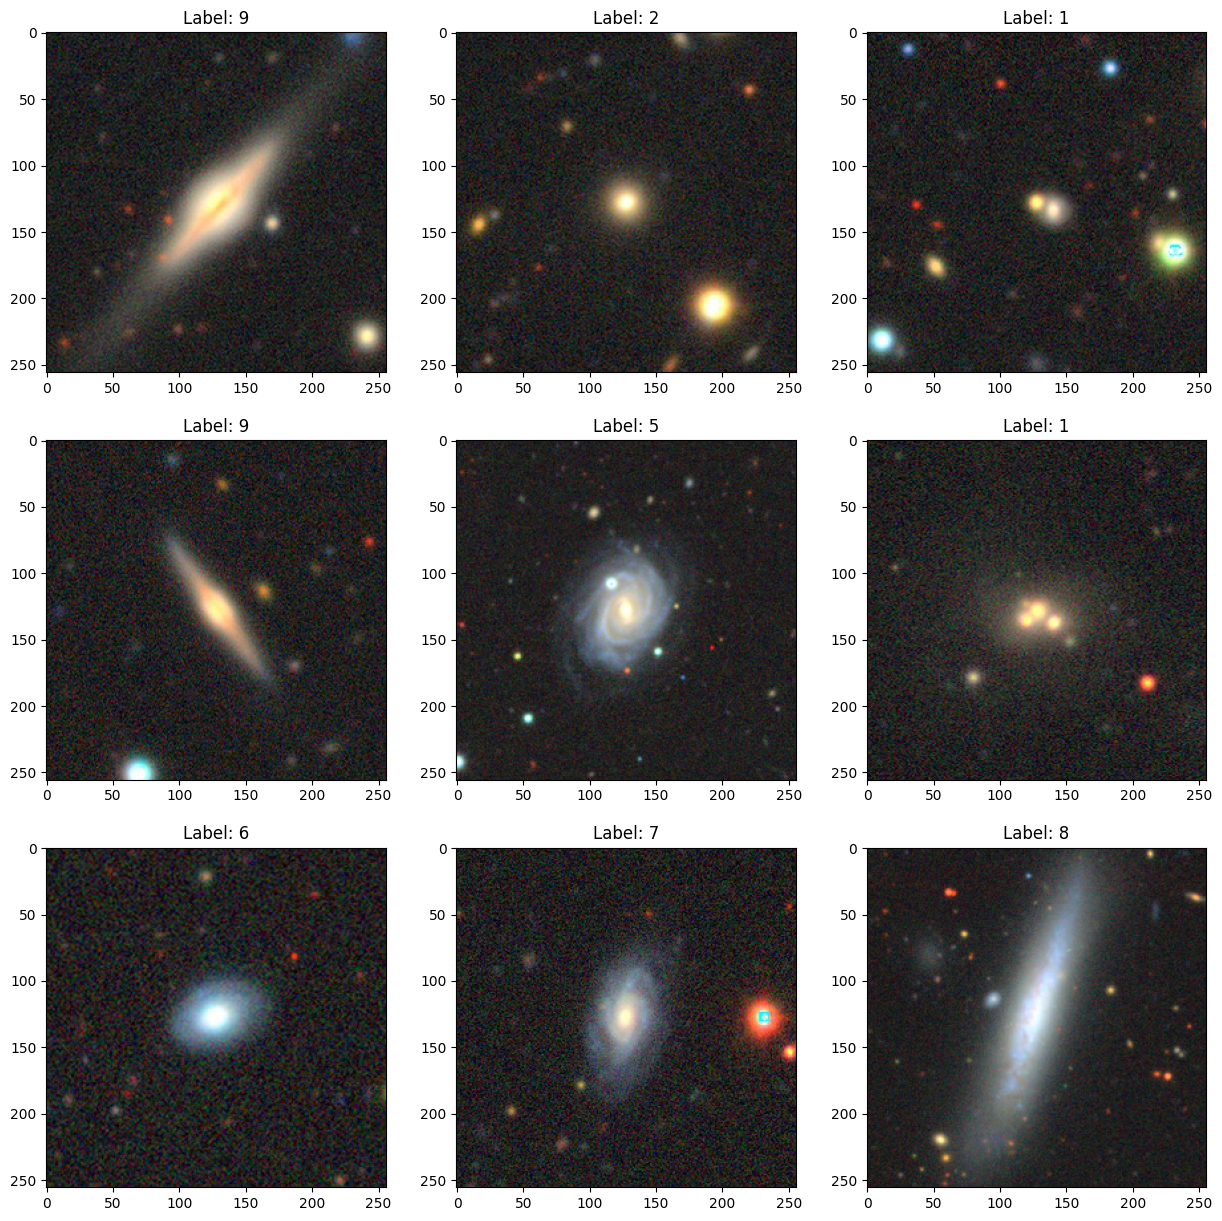

In [4]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    j = np.random.randint(0, images.shape[0])
    plt.title("Label: {}".format(labels[j]))
    plt.imshow(images[j])

In [5]:
256*256*3

196608

In [20]:
from sklearn.decomposition import PCA, IncrementalPCA, NMF, FastICA, MiniBatchNMF

In [7]:
pca = PCA(n_components=200)

In [7]:
flat_images = images.reshape((images.shape[0], -1))

In [8]:
flat_images.shape

(17736, 196608)

In [10]:
%%time
compressed_images = pca.fit_transform(flat_images)

CPU times: user 2h 32s, sys: 10min 36s, total: 2h 11min 8s
Wall time: 3min 47s


In [5]:
import pickle

def read_object(file):
    with open(file, 'rb') as fd:
        data = pickle.load(fd)
        fd.close()
    return data

def write_object(data, file):
    with open(file, 'wb') as fd:
        pickle.dump(data, fd)
        fd.close()

In [7]:
path_write = '/data/spcup2022/UDAY/DSmodels/'

In [47]:
write_object(pca, path_write + 'PCA_200.pkl')

In [11]:
import concurrent.futures

In [33]:
def fit_func(n_components, flat_images):
    pca = FastICA(n_components=n_components)
    pca.fit(flat_images)
    return pca

In [24]:
from tqdm import tqdm

In [ ]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_url = {executor.submit(fit_func, n_components, flat_images): n_components for n_components in [200, 300, 400, 500, 1000]}
    for future in tqdm(concurrent.futures.as_completed(future_to_url)):
        n_components = future_to_url[future]
        try:
            pca = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (n_components, exc))
        else:
            write_object(pca, path_write + 'ICA_{}.pkl'.format(n_components))

/home/spcup2022/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
/home/spcup2022/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
/home/spcup2022/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
/home/spcup2022/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
1it [00:30, 30.16s/it]

400 generated an exception: Unable to allocate 26.0 GiB for an array with shape (196608, 17736) and data type float64


2it [00:32, 13.70s/it]

1000 generated an exception: Unable to allocate 26.0 GiB for an array with shape (196608, 17736) and data type float64


In [30]:
p = np.unique(labels, return_counts=True)[1]/labels.shape[0]

In [31]:
labels_p = np.array([p[l] for l in labels])

In [44]:
for n_components in tqdm([200, 300, 400, 500, 1000]):
    eN = 2000
    idx = np.random.choice(np.arange(flat_images.shape[0]), size=eN)
    
    pca = fit_func(n_components, flat_images[idx])
    write_object(pca, path_write + 'ICA_{}.pkl'.format(n_components))

100%|████████████████████████████████████████████| 5/5 [15:49<00:00, 189.87s/it]


In [ ]:
for n_components in [300, 400, 500, 1000]:
    pca = PCA(n_components=200)
    pca.fit(flat_images)

In [11]:
%%time
decompressed_images = pca.inverse_transform(compressed_images)

CPU times: user 3min 8s, sys: 14.8 s, total: 3min 23s
Wall time: 22.5 s


In [12]:
decompressed_images = decompressed_images.reshape(images.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


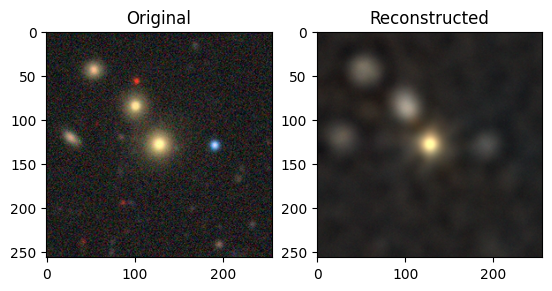

In [43]:
j = np.random.randint(0, images.shape[0])

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(images[j])


plt.subplot(1, 2, 2)
plt.title("Reconstructed")

dim = decompressed_images[j]
dim = 255*(dim)/(dim.max() - dim.min())
dim = dim.astype(np.int32)

plt.imshow(dim)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


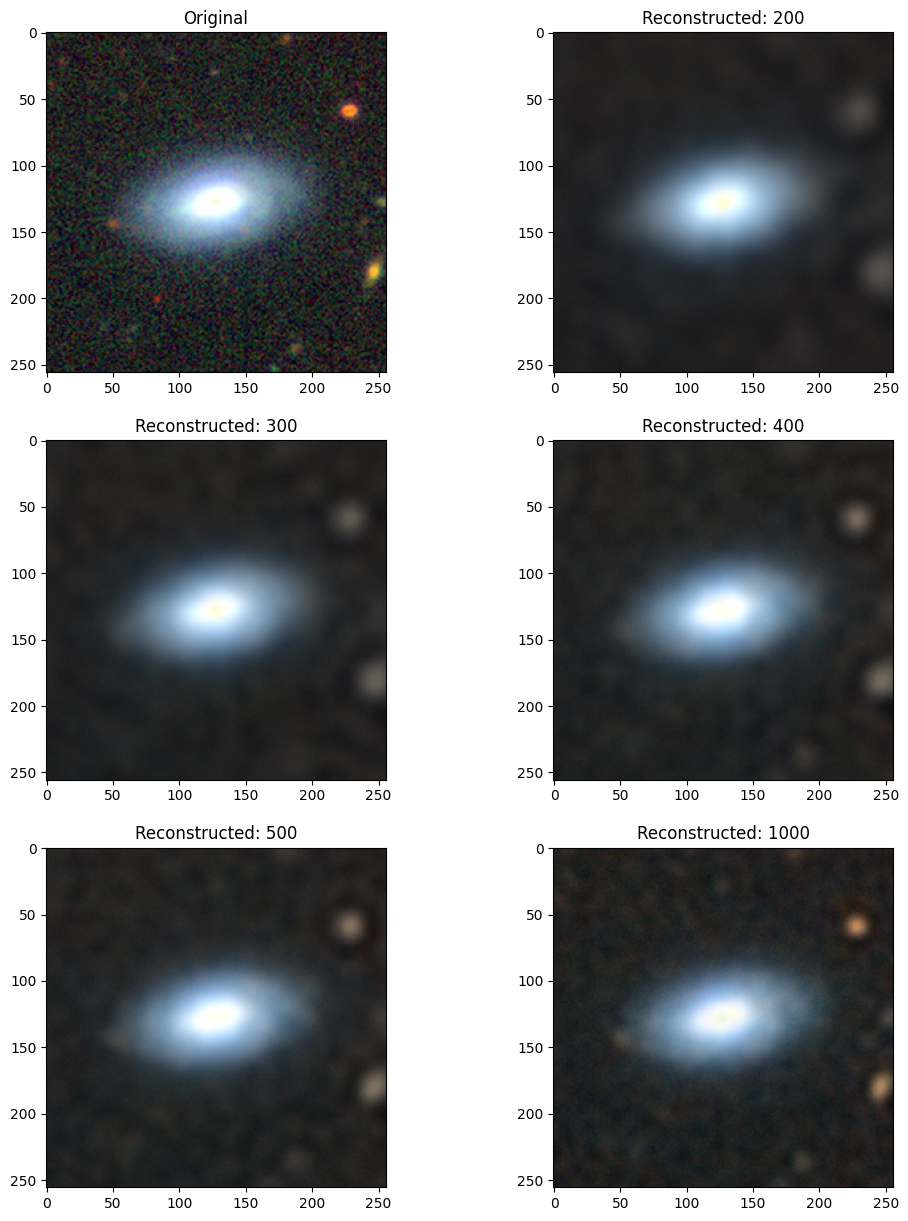

In [29]:
j = np.random.randint(0, images.shape[0])


plt.figure(figsize=(12, 15))

plt.subplot(3, 2, 1)
plt.title("Original")
plt.imshow(images[j])

for i, n_components in enumerate([200, 300, 400, 500, 1000]):
    pca = read_object(path_write + 'PCA_{}.pkl'.format(n_components))
        
    dim = pca.inverse_transform(pca.transform(images[j].reshape((1, -1)))).reshape(images[j].shape)
    
    
    plt.subplot(3, 2, i+2)
    plt.title("Reconstructed: {}".format(n_components))

    dim = 255*(dim)/(dim.max() - dim.min())
    dim = dim.astype(np.int32)

    plt.imshow(dim)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


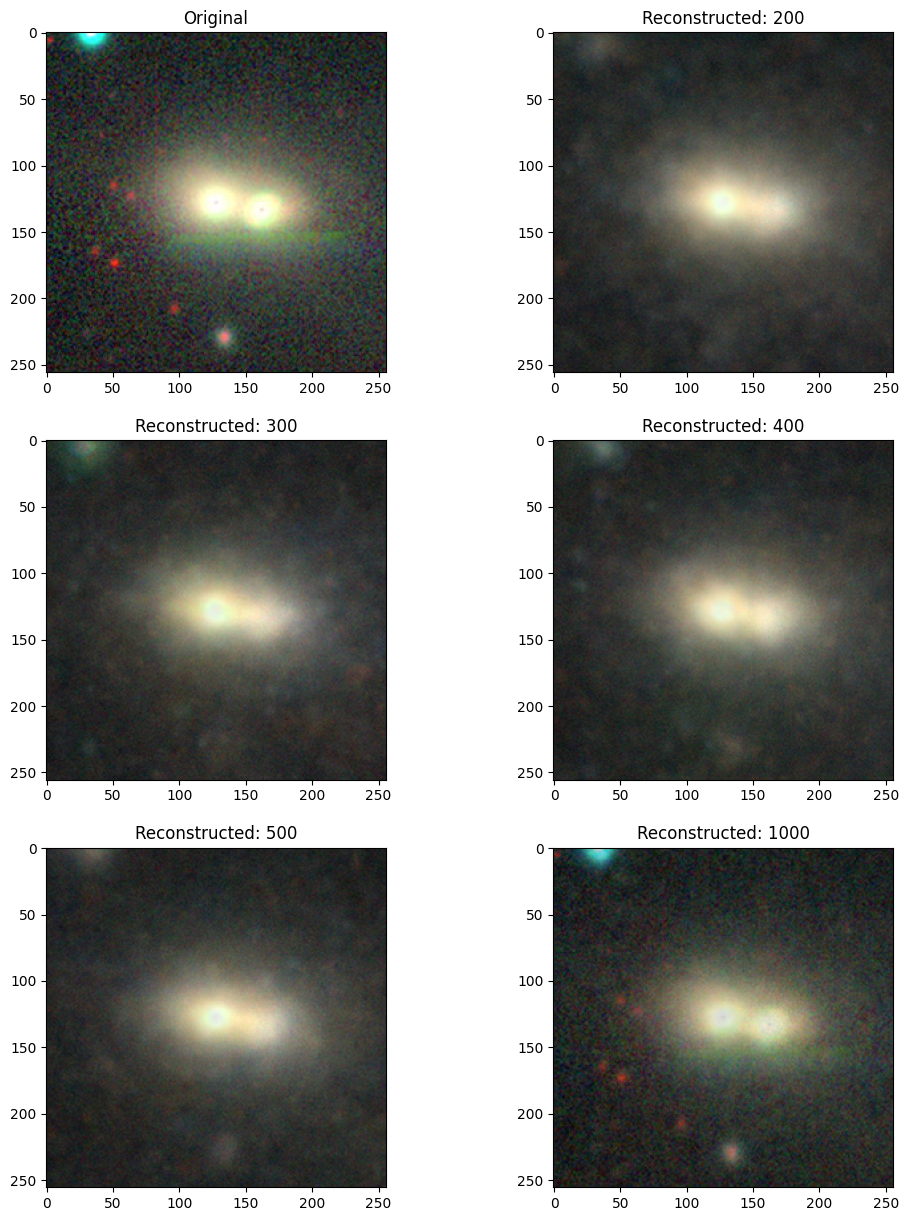

In [43]:
j = np.random.randint(0, images.shape[0])


plt.figure(figsize=(12, 15))

plt.subplot(3, 2, 1)
plt.title("Original")
plt.imshow(images[j])

for i, n_components in enumerate([200, 300, 400, 500, 1000]):
    pca = read_object(path_write + 'ICA_{}.pkl'.format(n_components))
        
    dim = pca.inverse_transform(pca.transform(images[j].reshape((1, -1)))).reshape(images[j].shape)
    
    
    plt.subplot(3, 2, i+2)
    plt.title("Reconstructed: {}".format(n_components))

    dim = 255*(dim)/(dim.max() - dim.min())
    dim = dim.astype(np.int32)

    plt.imshow(dim)

In [11]:
alg = 'PCA'
path = 'results/'+alg+'_{}_{}.jpeg'

for i in idxs:
    for n_components in [200, 300, 400, 500, 1000]:
        pca = read_object(path_write + '{}_{}.pkl'.format(alg, n_components))

        dim = pca.inverse_transform(pca.transform(images[i].reshape((1, -1)))).reshape(images[i].shape)


    #     plt.subplot(3, 2, i+2)
    #     plt.title("Reconstructed: {}".format(n_components))

        dim = np.clip(dim, 0, 255)
        dim = dim.astype(np.uint8)

        plt.imsave(path.format(i, n_components), dim)

In [12]:
path = 'results/{}.jpeg'
for i in idxs:
    plt.imsave(path.format(i), dim)